In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools
from typing import List, Dict, Callable

DATA_DIR = "../data"

## 1. Data Loading

In [3]:
data = pd.read_csv(f"{DATA_DIR}/medium.csv")
data

,Title,Text
0,A Beginner’s Guide to Word Embedding with Gens...,1. Introduction of Word2vec\n\nWord2vec is one...
1,Hands-on Graph Neural Networks with PyTorch & ...,"In my last article, I introduced the concept o..."
2,How to Use ggplot2 in Python,Introduction\n\nThanks to its strict implement...
3,Databricks: How to Save Data Frames as CSV Fil...,Photo credit to Mika Baumeister from Unsplash\...
4,A Step-by-Step Implementation of Gradient Desc...,A Step-by-Step Implementation of Gradient Desc...
...,...,...
1386,Brain: A Mystery,“The most beautiful experience we can have is ...
1387,Machine Learning: Lincoln Was Ahead of His Time,Photo by Jp Valery on Unsplash\n\nIn the 45th ...
1388,AI and Us — an Opera Experience. In my previou...,EKHO COLLECTIVE: OPERA BEYOND SERIES\n\nIn my ...
1389,Digital Skills as a Service (DSaaS),Have you ever thought about what will be in th...


## 2. Data Preprocessing

In [17]:
paragraphs = data["Text"].str.split("\n\n").explode()
pars_df = paragraphs.reset_index().rename(columns={"index": "article_idx"})
pars_df

,article_idx,Text
0,0,1. Introduction of Word2vec
1,0,Word2vec is one of the most popular technique ...
2,0,There are two main training algorithms for wor...
3,0,2. Gensim Python Library Introduction
4,0,Gensim is an open source python library for na...
...,...,...
50219,1390,PII refers to information that can be used to ...
50220,1390,"For anyone that works with data about people, ..."
50221,1390,Conclusion: We’re Still Working On It
50222,1390,It is perhaps unsatisfying to know that no per...


In [18]:
def groups_to_dict(groups: List[List[int]]) -> Dict[int, int]:
    """Creates mapping from element to index of group it belongs to

    Args:
        groups (List[List[int]]): list of groups of elements

    Returns:
        Dict[int, int]: dictionary representing mapping element -> group_idx
    """
    elem_to_group = {}
    for i, group in enumerate(groups):
        for elem in group:
            elem_to_group[elem] = i
    return elem_to_group


def collapse_df_by_inds(df: pd.DataFrame, groups: List[List[int]], agg_mapping: Dict[str, Callable]) -> pd.DataFrame:
    """Aggregates rows of dataframe within specified groups using functions specified in 'agg_mapping'

    Args:
        df (pd.DataFrame): dataframe, rows of which should be aggregated
        groups (List[List[int]]): list of groups of indices from 'df' 
        agg_mapping (Dict[str, Callable]): dictionary mapping (column_name -> agg_function)

    Returns:
        pd.DataFrame: result of aggregating within groups
    """
    idx_to_group = groups_to_dict(groups)

    grouped = df.groupby(
        pd.Series(df.index).apply(idx_to_group.__getitem__)
    ).agg(agg_mapping).reset_index(drop=True)
    return grouped

### Dealing with code 
- Classifying lines containing code through a set of regex patterns
- Grouping consecutive lines of code into a single paragraph

**Note**: of course, these regex patterns are just a heuristic and work only for Python (will work poorly for other languages and command line commands). Ideally, we would train some classifier to classify whether a given strip of text is code or not. It could be a `NaiveBayes`, `SVM`, `LSTM` or any other suitable one. However here, due to lack of labeled data and time contraints, we decided to move forward with regex patterns 

In [19]:
def count_pattern_matches(texts: pd.Series, patterns: Dict[str, str]) -> pd.DataFrame:
    """For each entry in a series, counts the number of matches for each pattern

    Args:
        texts (pd.Series): series of type 'str' 
        patterns (Dict[str, str]): dictionary where keys are pattern names and values are regex string patterns

    Returns:
        pd.DataFrame: dataframe of shape (len(texts), len(patterns)) where column names are the pattern names given in 'patterns' 
    """
    df_with_matches = pd.DataFrame()
    for patt_name, patt in patterns.items():
        df_with_matches[patt_name] = texts.str.count(patt)
    return df_with_matches

In [20]:
patterns = {
    "call": r"^[\w.]+\(",
    "getitem": r"^[\w.]+\[",
    "import": r"(^import |^from [\w.]+ import)",
    "class_def": r"^class \w+:$",
    "func_def": r"^def \w+\(",
    "return": r"^(return|yield|raise) ",
    "exception": r"^(try|catch|finally) .+:",
    "comment": r"#+ \w+",
    "loop": r"^(for|while) .+:",
    "if": r"^(if|else) .+:",
    "assign": r"^[\w.]+ ?[+\-\/*]?= ?.+",
    "no_letters": r"^[^A-Za-z]*$"
}

match_counts = count_pattern_matches(pars_df["Text"], patterns=patterns)

code_suspects = pars_df.loc[match_counts.sum(axis=1) > 0]
code_suspects

,article_idx,Text
27,0,# Select features from original dataset to for...
28,0,">>> df1 = df[['Engine Fuel Type','Transmission..."
29,0,">>> df2 = df1.apply(lambda x: ','.join(x.astyp..."
30,0,>>> df_clean = pd.DataFrame({'clean': df2}) # ...
31,0,">>> sent = [row.split(',') for row in df_clean..."
...,...,...
50076,1380,}
50107,1384,"df = CSV.read(""Summary of Weather.csv"")"
50111,1384,df.Date = [i = DateTime(i) for i in df.Date]
50112,1384,df.Date = [i = year(i) for i in df.Date]


In [21]:
def group_by_consecutive_blocks(df: pd.DataFrame, indices: np.ndarray) -> List[List[int]]:
    is_code_mask = np.zeros(len(pars_df), dtype=np.bool_)
    is_code_mask[indices] = True

    temp_df = df.copy()
    temp_df["in_indices"] = is_code_mask
    groups = []
    for art_idx in temp_df["article_idx"].unique():
        article_df: pd.DataFrame = temp_df.loc[temp_df["article_idx"] == art_idx]
        for val, group in itertools.groupby(article_df.index, key=article_df["in_indices"].__getitem__):
            if val:
                groups.append(list(group))
            else:
                groups.extend([[elem] for elem in group])
    return groups

In [22]:
groups = group_by_consecutive_blocks(pars_df, code_suspects.index.to_numpy())
reduced_pars_df = collapse_df_by_inds(
    pars_df,
    groups,
    agg_mapping={
        "article_idx": lambda idxs: idxs.mode(),
        "Text": "\n".join
    }
)
reduced_pars_df

,article_idx,Text
0,0,1. Introduction of Word2vec
1,0,Word2vec is one of the most popular technique ...
2,0,There are two main training algorithms for wor...
3,0,2. Gensim Python Library Introduction
4,0,Gensim is an open source python library for na...
...,...,...
44188,1390,PII refers to information that can be used to ...
44189,1390,"For anyone that works with data about people, ..."
44190,1390,Conclusion: We’re Still Working On It
44191,1390,It is perhaps unsatisfying to know that no per...


### Semantic Chunking

In [23]:
def get_cos_sims(embeds: np.ndarray) -> np.ndarray:
    norms = np.linalg.norm(embeds, axis=1)
    return (embeds[1:] * embeds[:-1]).sum(axis=1) / norms[1:] / norms[:-1]


def group_by_consecutive_sims(df: pd.DataFrame, embeds: np.ndarray, std_multiplier=0.5) -> List[List[int]]:
    assert "article_idx" in df.columns

    embed_sims = get_cos_sims(embeds)
    sim_mean, sim_std = embed_sims.mean(), embed_sims.std()

    groups = []
    for art_idx in df["article_idx"].unique():
        art_par_idxs = df.index[df["article_idx"] == art_idx].to_list()
        curr_group = [art_par_idxs[0]]
        for i in range(1, len(art_par_idxs)):
            if embed_sims[i-1] > (sim_mean + std_multiplier * sim_std):
                curr_group.append(art_par_idxs[i])
            else:
                groups.append(curr_group)
                curr_group = [art_par_idxs[i]]
        if len(curr_group) > 0:
            groups.append(curr_group)

    return groups


from langchain.embeddings.huggingface import HuggingFaceEmbeddings
def calc_embeddings(texts: List[str], model_name: str) -> np.ndarray:
    hf_embeddings = HuggingFaceEmbeddings(model_name=model_name)
    embeds = np.array(hf_embeddings.embed_documents(texts))
    return embeds

In [24]:
## OPTION 1: GENERATE EMBEDDINGS AND SAVE THEM
par_embeds = calc_embeddings(texts=reduced_pars_df["Text"].to_list(), model_name="all-MiniLM-L6-v2")

## OPTION 2: LOAD PREGENERATED EMBEDDINGS
# par_embeds = np.load(f"{DATA_DIR}/par_embeds.npy")

In [31]:
STD_MULTIPLIER = 0.5
groups = group_by_consecutive_sims(reduced_pars_df, par_embeds, std_multiplier=STD_MULTIPLIER)
grouped_pars = collapse_df_by_inds(
    reduced_pars_df.loc[:, ["article_idx","Text"]],
    groups,
    agg_mapping={
        "article_idx": lambda idxs: idxs.mode(),
        "Text": lambda texts: "\n\n".join(texts),
    }
)
grouped_pars = grouped_pars.merge(data["Title"], left_on="article_idx", right_on=data.index)
grouped_pars = grouped_pars.reset_index(names="paragraph_idx")
grouped_pars

,paragraph_idx,article_idx,Text,Title
0,0,0,1. Introduction of Word2vec\n\nWord2vec is one...,A Beginner’s Guide to Word Embedding with Gens...
1,1,0,2. Gensim Python Library Introduction\n\nGensi...,A Beginner’s Guide to Word Embedding with Gens...
2,2,0,"Python >= 2.7 (tested with versions 2.7, 3.5 a...",A Beginner’s Guide to Word Embedding with Gens...
3,3,0,>= 1.5.0 smart_open >= 1.2.1,A Beginner’s Guide to Word Embedding with Gens...
4,4,0,There are two ways for installation. We could ...,A Beginner’s Guide to Word Embedding with Gens...
...,...,...,...,...
25733,25733,1390,Data Storage & Publication: Show your work?,Primer on The Importance of Mindful Data Colle...
25734,25734,1390,"In the current era, in order to stay relevant ...",Primer on The Importance of Mindful Data Colle...
25735,25735,1390,"For anyone that works with data about people, ...",Primer on The Importance of Mindful Data Colle...
25736,25736,1390,It is perhaps unsatisfying to know that no per...,Primer on The Importance of Mindful Data Colle...


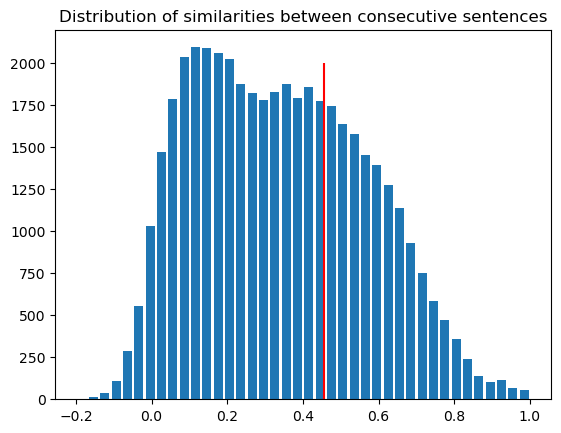

In [26]:
embed_sims = get_cos_sims(par_embeds)
plt.hist(embed_sims, bins=40, rwidth=0.8)
plt.vlines([embed_sims.mean() + STD_MULTIPLIER*embed_sims.std()], [0], [2000], colors=["red"])
plt.title("Distribution of similarities between consecutive sentences")
plt.show()

In [32]:
code_suspects.to_csv(f"{DATA_DIR}/code_suspects.csv")

reduced_pars_df.to_csv(
    f"{DATA_DIR}/reduced_paragraphs.csv",
    index=False
)

np.save(f"{DATA_DIR}/par_embeds.npy", par_embeds)

grouped_pars.to_csv(
    f"{DATA_DIR}/grouped_paragraphs.csv", 
    index=False
)